# physik690 - Bachelorarbeit

In [195]:
# Standard imports for computational physics
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress
import pandas as pd
from enum import Enum
import sqlite3
import scienceplots

# Pretty styling for graphs
plt.style.use(['science', 'grid', 'scatter'])
plt.rcParams["figure.figsize"] = (10, 6)

dpi = 300

In [196]:
class Algorithm(Enum):
    Metropolis = 0
    Wolff = 1

class Observable(Enum):
    Energy = 0
    EnergySquare = 1
    Magnetization = 2
    MagnetizationSquare = 3
    SpecificHeat = 4
    MagneticSusceptibility = 5
    HelicityModulus = 7

    def name(self) -> str:
        match self:
            case Observable.Energy:
                return "Energy"
            case Observable.EnergySquare:
                return "Energy squared"
            case Observable.Magnetization:
                return "Magnetization"
            case Observable.MagnetizationSquare:
                return "Magnetization squared"
            case Observable.SpecificHeat:
                return "Specific heat"
            case Observable.MagneticSusceptibility:
                return "Magnetic susceptibility"
            case Observable.HelicityModulus:
                return "Helicity Modulus"

    def symbol(self) -> str:
        match self:
            case Observable.Energy:
                return "E"
            case Observable.EnergySquare:
                return "E^2"
            case Observable.Magnetization:
                return "M"
            case Observable.MagnetizationSquare:
                return "M^2"
            case Observable.SpecificHeat:
                return "C_V"
            case Observable.MagneticSusceptibility:
                return "\\chi"
            case Observable.HelicityModulus:
                return "\\Gamma"

In [197]:
def plot_observable_per_spin(con: sqlite3.Connection, simulation_id: int, alg: Algorithm, observable: Observable) -> tuple[plt.Figure, plt.Axes]:
    fig, ax = plt.subplots()
    for size in pd.read_sql_query(f'SELECT DISTINCT lattice_size FROM configurations c INNER JOIN metadata m ON c.metadata_id = m.metadata_id AND m.algorithm = {alg.value} WHERE c.simulation_id = {simulation_id}', con)['lattice_size']:
        data = pd.read_sql_query(f'SELECT temperature, e.mean, e.std_dev FROM configurations c INNER JOIN metadata m ON c.metadata_id = m.metadata_id AND m.algorithm = {alg.value} INNER JOIN estimates e ON e.configuration_id = c.configuration_id AND e.type_id = {observable.value} WHERE c.simulation_id = \'{simulation_id}\' AND c.lattice_size = \'{size}\' ORDER BY temperature', con)
        ax.errorbar(data['temperature'], data['mean'], label=f'$N = {size} \\times {size}$')

        ax.set_title(f'{observable.name()} per spin for a 2D lattice using the {alg.name} algorithm')
        ax.set_xlabel('Temperature $T / \\frac{J}{k_B}$')
        ax.set_ylabel(f'{observable.name()} per spin ${observable.symbol()}$')

        ax.legend()
    return fig, ax

def get_observable_max(con: sqlite3.Connection, simulation_id: int, alg: Algorithm, observable: Observable) -> pd.DataFrame:
    return pd.read_sql_query(f'SELECT lattice_size, temperature, MAX(mean) FROM configurations c INNER JOIN metadata m ON c.metadata_id = m.metadata_id AND m.algorithm = {alg.value} INNER JOIN estimates e ON e.configuration_id = c.configuration_id AND e.type_id = {observable.value} WHERE c.simulation_id = \'{simulation_id}\' AND c.temperature BETWEEN 0.8 AND 1.2 AND lattice_size >= 20 GROUP BY c.lattice_size', con)

In [198]:
def plot_observable_integrated_autocorrelation(con: sqlite3.Connection, simulation_id: int, alg: Algorithm, observable: Observable):
    fig, ax = plt.subplots()
    for size in pd.read_sql_query(f'SELECT DISTINCT lattice_size FROM configurations c INNER JOIN metadata m ON c.metadata_id = m.metadata_id AND m.algorithm = {alg.value} WHERE c.simulation_id = {simulation_id}', con)['lattice_size']:
        data = pd.read_sql_query(f'SELECT temperature, tau FROM configurations c INNER JOIN metadata m ON c.metadata_id = m.metadata_id AND m.algorithm = {alg.value} INNER JOIN chunks ch ON ch.configuration_id = c.configuration_id AND ch."index" = 1 INNER JOIN results r ON r.chunk_id = ch.chunk_id AND r.type_id = {observable.value} WHERE c.simulation_id = \'{simulation_id}\' AND c.lattice_size = \'{size}\' ORDER BY temperature', con)
        ax.errorbar(data['temperature'], data['tau'], label=f'$N = {size} \\times {size}$')

        ax.set_title(f'{observable.name()} integrated autocorrelation time for a 2D lattice using the {alg.name} algorithm')
        ax.set_xlabel('Temperature $T / \\frac{J}{k_B}$')
        ax.set_ylabel(f'{observable.name()} per spin $\\tau$')

        #ax.set_yscale('log')
        ax.legend()
    return fig, ax

In [199]:
con = sqlite3.connect('output/data.db')
simulation_id = pd.read_sql_query('SELECT simulation_id FROM simulations ORDER BY created_at DESC', con).at[0, 'simulation_id']
print(f'The current simulation id is {simulation_id}')

The current simulation id is 0


# Energy

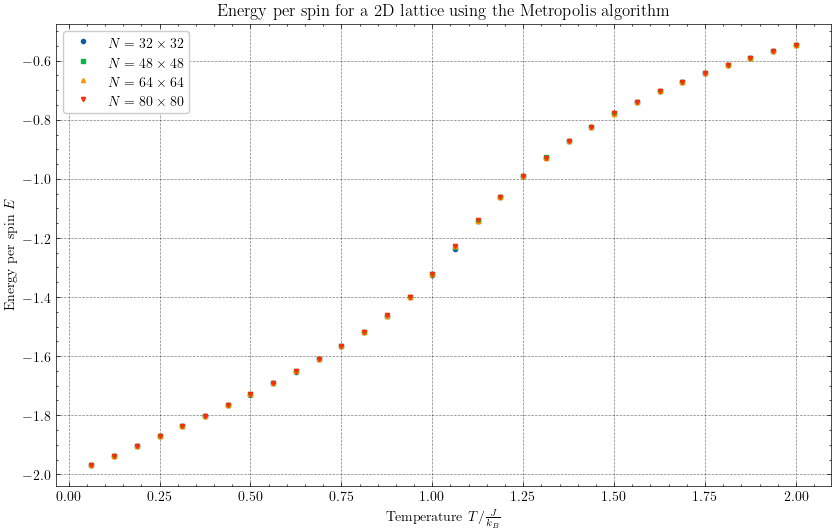

In [200]:
fig, _ = plot_observable_per_spin(con, simulation_id, Algorithm.Metropolis, Observable.Energy)
fig.savefig('figures/Metropolis/Energy.pdf', dpi=dpi,  bbox_inches='tight')

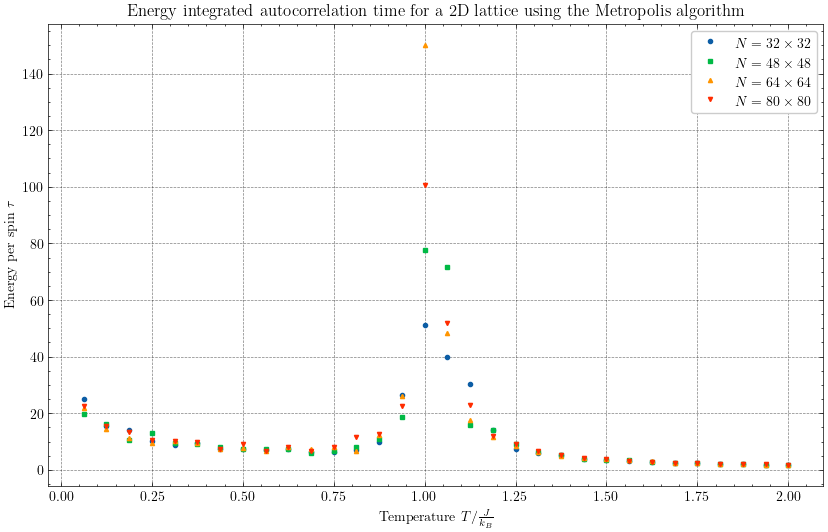

In [201]:
fig, _ = plot_observable_integrated_autocorrelation(con, simulation_id, Algorithm.Metropolis, Observable.Energy)
fig.savefig('figures/Metropolis/Energy_IntegratedAutocorrelation.pdf', dpi=dpi,  bbox_inches='tight')

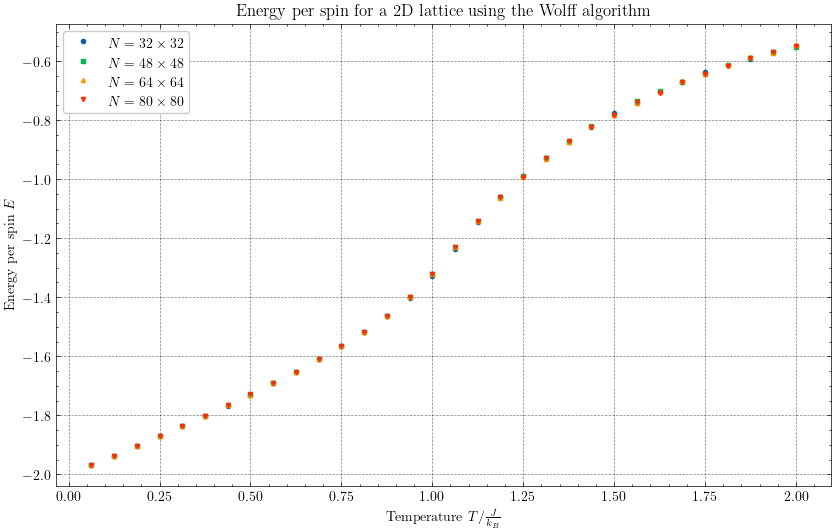

In [202]:
fig, _ = plot_observable_per_spin(con, simulation_id, Algorithm.Wolff, Observable.Energy)
fig.savefig('figures/Wolff/Energy.pdf', dpi=dpi,  bbox_inches='tight')

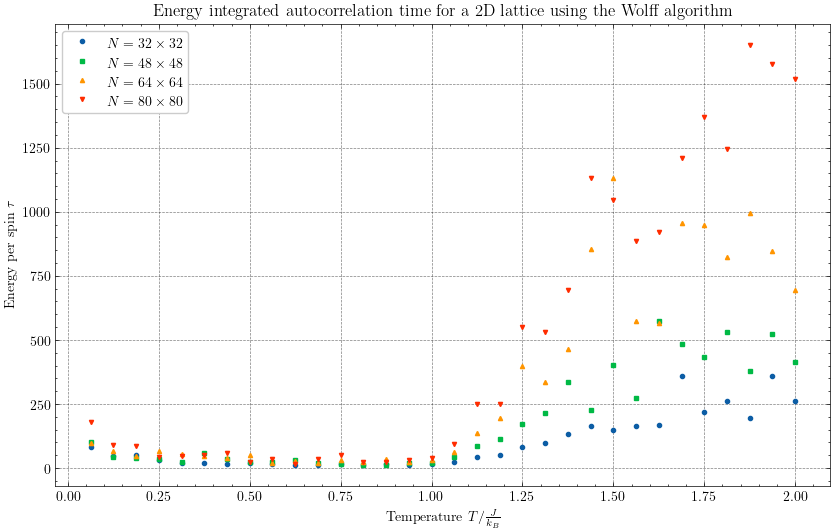

In [203]:
fig, _ = plot_observable_integrated_autocorrelation(con, simulation_id, Algorithm.Wolff, Observable.Energy)
fig.savefig('figures/Wolff/Energy_IntegratedAutocorrelation.pdf', dpi=dpi,  bbox_inches='tight')

# Energy Square

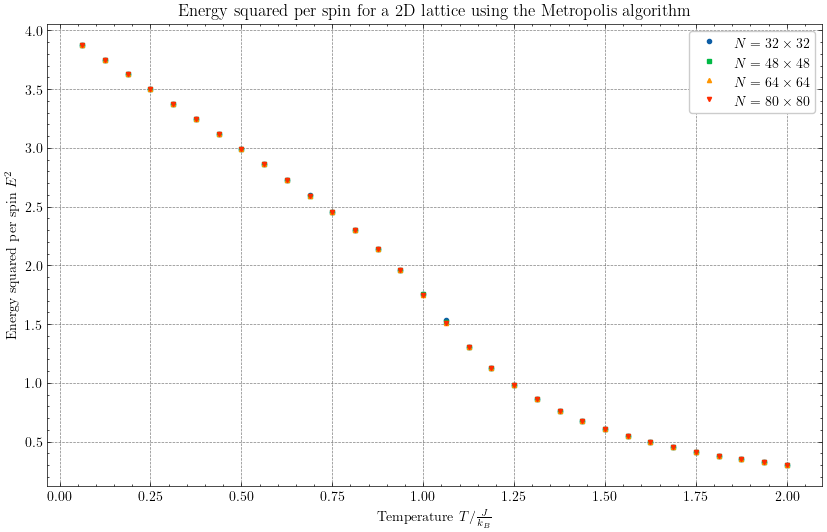

In [204]:
fig, _ = plot_observable_per_spin(con, simulation_id, Algorithm.Metropolis, Observable.EnergySquare)
fig.savefig('figures/Metropolis/EnergySquare.pdf', dpi=dpi,  bbox_inches='tight')

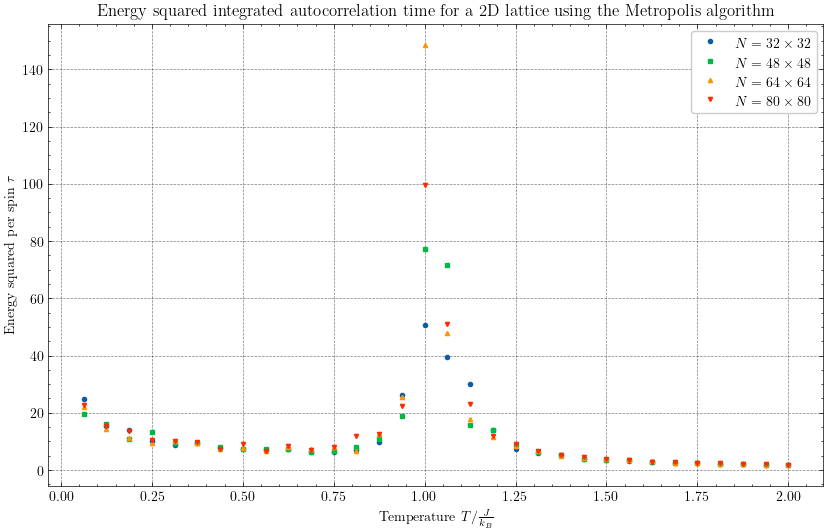

In [205]:
fig, _ = plot_observable_integrated_autocorrelation(con, simulation_id, Algorithm.Metropolis, Observable.EnergySquare)
fig.savefig('figures/Metropolis/EnergySquare_IntegratedAutocorrelation.pdf', dpi=dpi,  bbox_inches='tight')

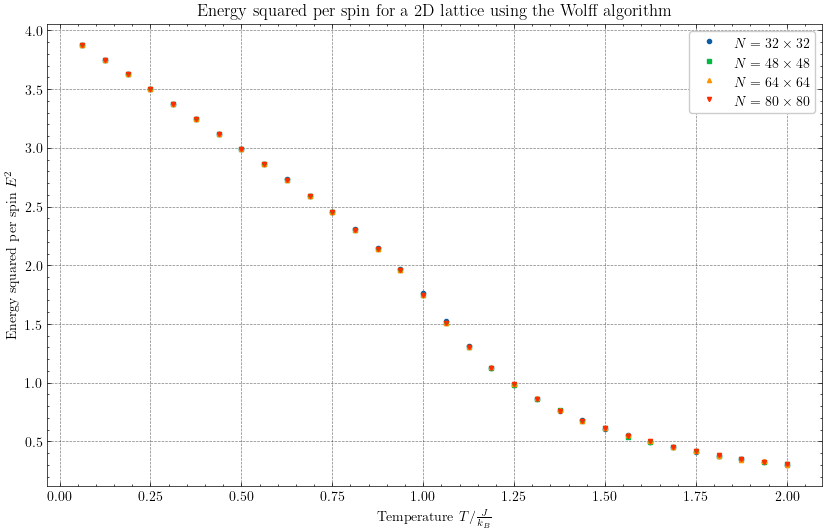

In [206]:
fig, _ = plot_observable_per_spin(con, simulation_id, Algorithm.Wolff, Observable.EnergySquare)
fig.savefig('figures/Wolff/EnergySquare.pdf', dpi=dpi,  bbox_inches='tight')

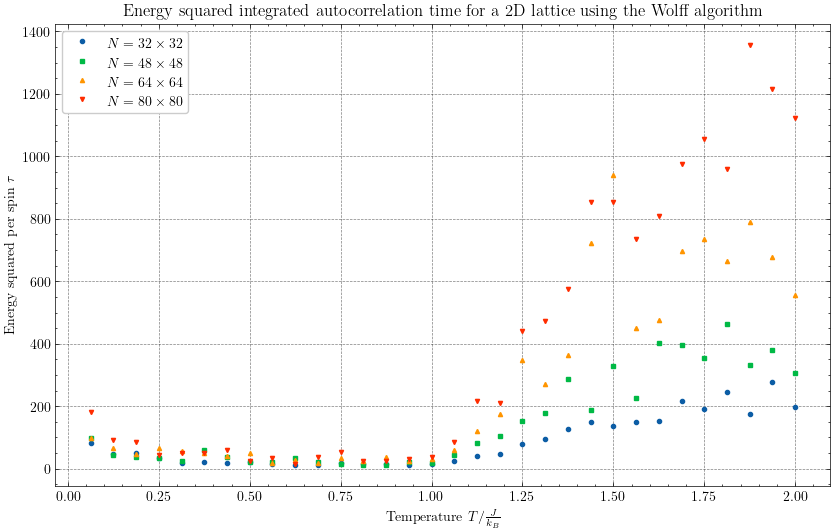

In [207]:
fig, _ = plot_observable_integrated_autocorrelation(con, simulation_id, Algorithm.Wolff, Observable.EnergySquare)
fig.savefig('figures/Wolff/EnergySquare_IntegratedAutocorrelation.pdf', dpi=dpi,  bbox_inches='tight')

# Specific heat

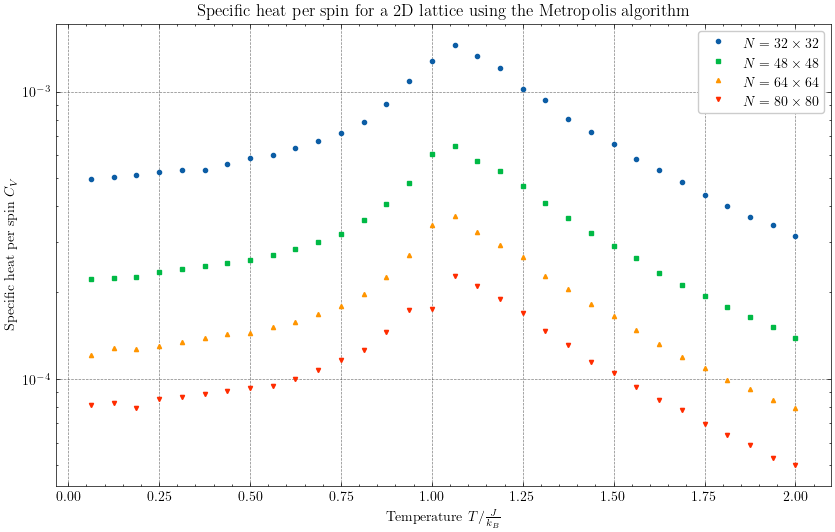

In [208]:
fig, ax = plot_observable_per_spin(con, simulation_id, Algorithm.Metropolis, Observable.SpecificHeat)
ax.set_yscale('log')
fig.savefig('figures/Metropolis/SpecificHeat.pdf', dpi=dpi,  bbox_inches='tight')

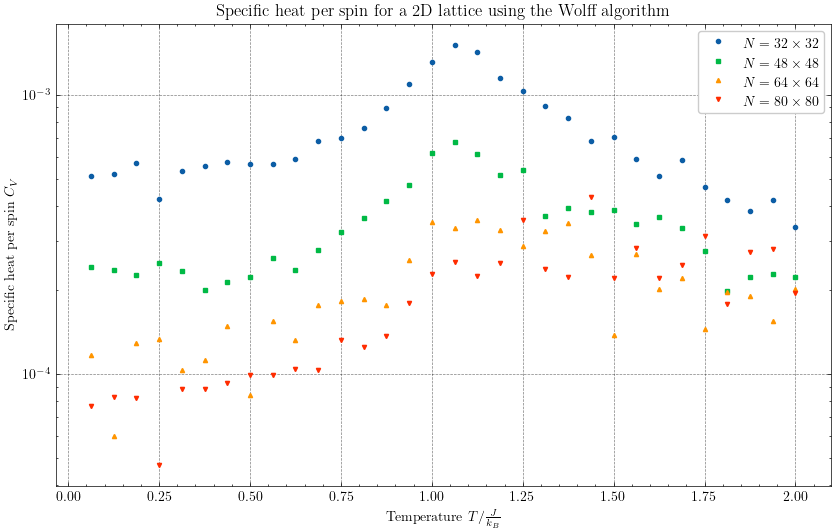

In [209]:
fig, ax = plot_observable_per_spin(con, simulation_id, Algorithm.Wolff, Observable.SpecificHeat)
ax.set_yscale('log')
fig.savefig('figures/Wolff/SpecificHeat.pdf', dpi=dpi,  bbox_inches='tight')

# Magnetization

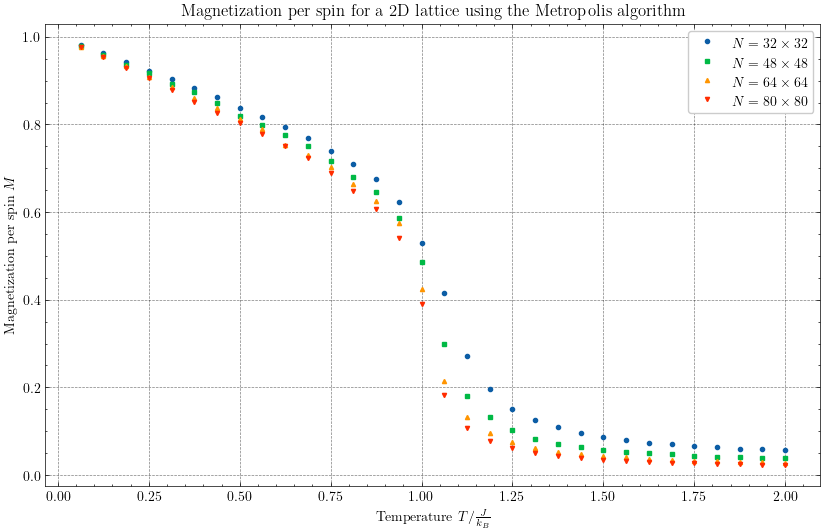

In [210]:
fig, _ = plot_observable_per_spin(con, simulation_id, Algorithm.Metropolis, Observable.Magnetization)
fig.savefig('figures/Metropolis/Energy.pdf', dpi=dpi,  bbox_inches='tight')

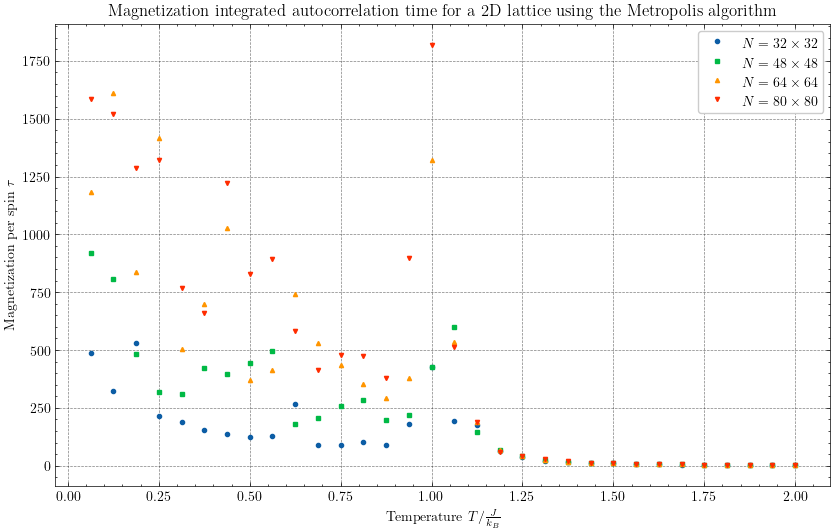

In [211]:
fig, _ = plot_observable_integrated_autocorrelation(con, simulation_id, Algorithm.Metropolis, Observable.Magnetization)
fig.savefig('figures/Metropolis/Magnetization_IntegratedAutocorrelation.pdf', dpi=dpi,  bbox_inches='tight')

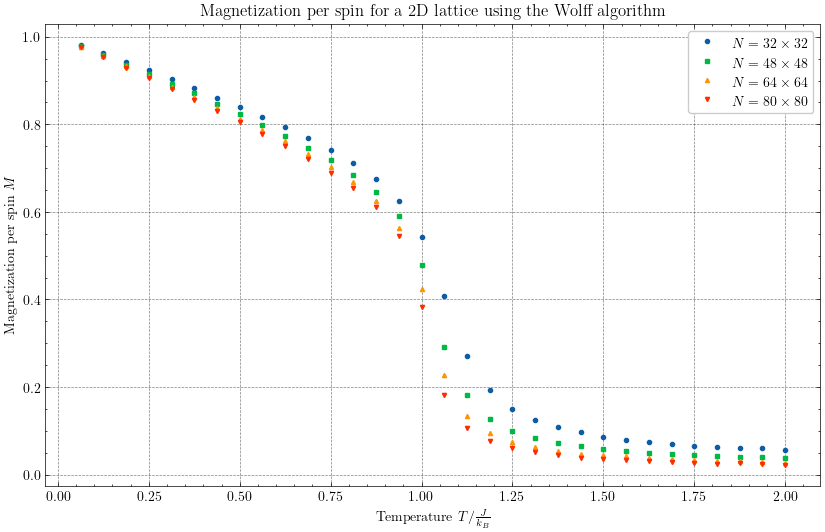

In [212]:
fig, _ = plot_observable_per_spin(con, simulation_id, Algorithm.Wolff, Observable.Magnetization)
fig.savefig('figures/Wolff/Magnetization.pdf', dpi=dpi,  bbox_inches='tight')

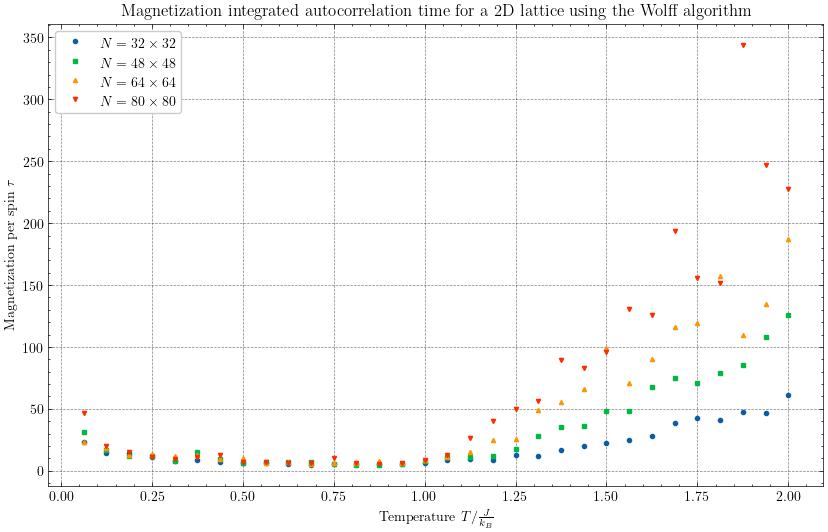

In [213]:
fig, _ = plot_observable_integrated_autocorrelation(con, simulation_id, Algorithm.Wolff, Observable.Magnetization)
fig.savefig('figures/Wolff/Magnetization_IntegratedAutocorrelation.pdf', dpi=dpi,  bbox_inches='tight')

# Magnetization squared

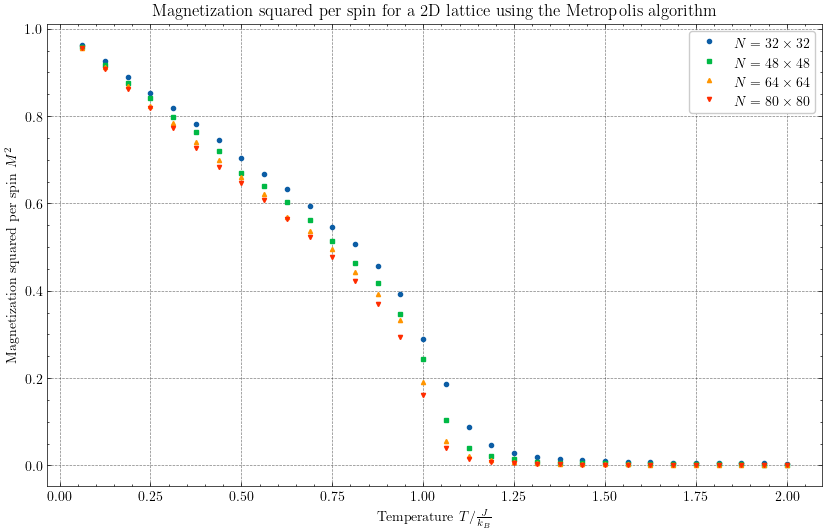

In [214]:
fig, _ = plot_observable_per_spin(con, simulation_id, Algorithm.Metropolis, Observable.MagnetizationSquare)
fig.savefig('figures/Metropolis/MagnetizationSquare.pdf', dpi=dpi,  bbox_inches='tight')

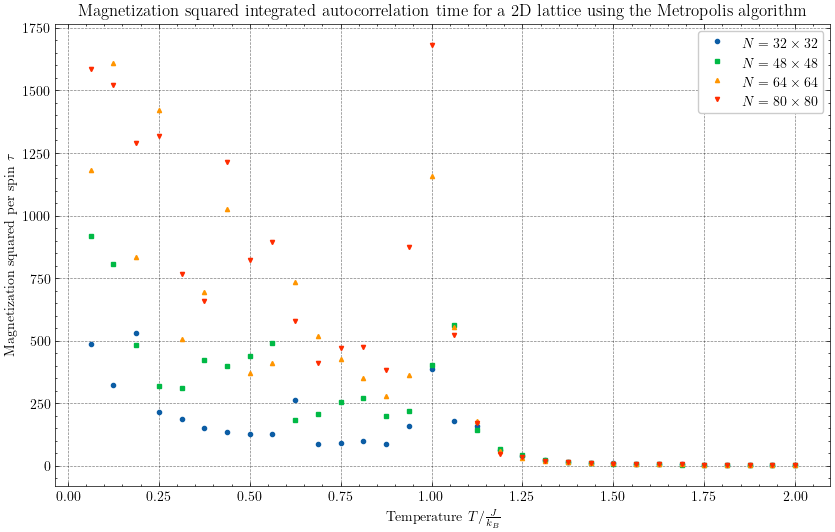

In [215]:
fig, _ = plot_observable_integrated_autocorrelation(con, simulation_id, Algorithm.Metropolis, Observable.MagnetizationSquare)
fig.savefig('figures/Metropolis/MagnetizationSquare_IntegratedAutocorrelation.pdf', dpi=dpi,  bbox_inches='tight')

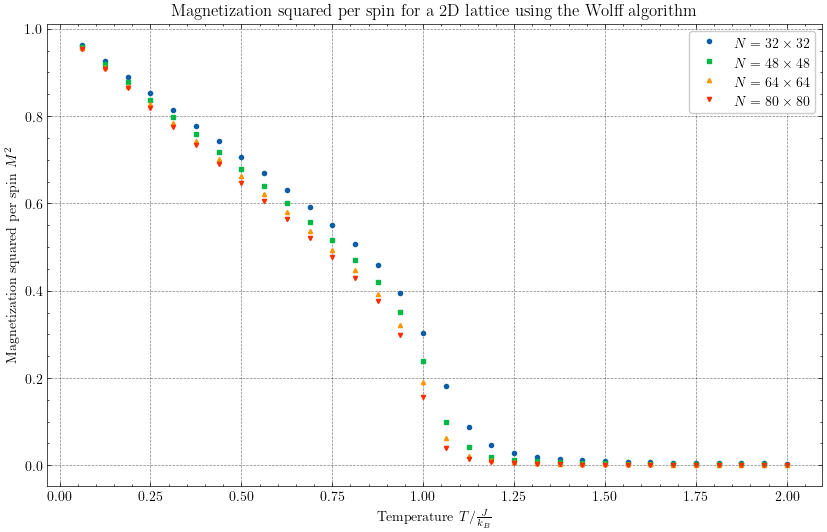

In [216]:
fig, _ = plot_observable_per_spin(con, simulation_id, Algorithm.Wolff, Observable.MagnetizationSquare)
fig.savefig('figures/Wolff/MagnetizationSquare.pdf', dpi=dpi,  bbox_inches='tight')

# Magnetic Susceptibility

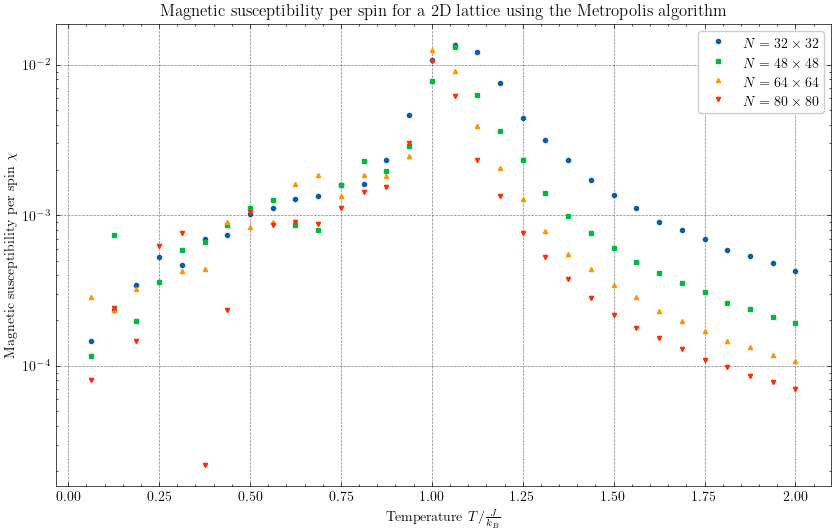

In [217]:
fig, ax = plot_observable_per_spin(con, simulation_id, Algorithm.Metropolis, Observable.MagneticSusceptibility)
ax.set_yscale('log')
fig.savefig('figures/Metropolis/MagneticSusceptibility.pdf', dpi=dpi,  bbox_inches='tight')

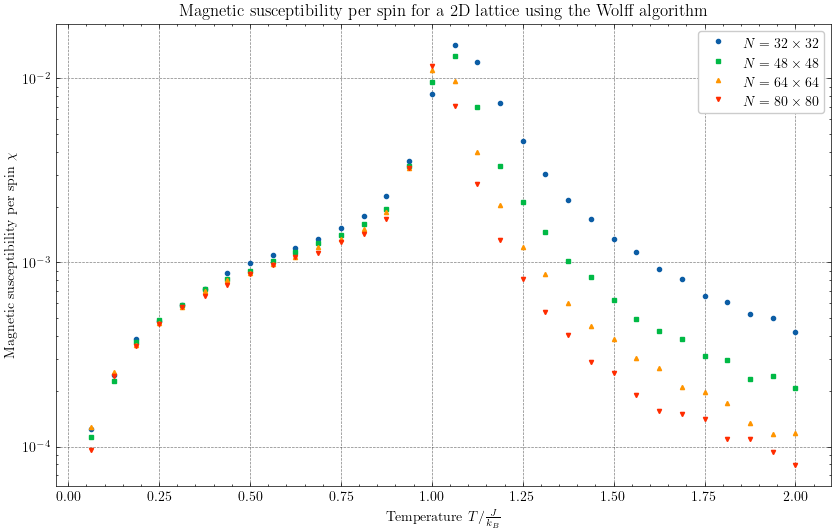

In [218]:
fig, ax = plot_observable_per_spin(con, simulation_id, Algorithm.Wolff, Observable.MagneticSusceptibility)
ax.set_yscale('log')
fig.savefig('figures/Wolff/MagneticSusceptibility.pdf', dpi=dpi,  bbox_inches='tight')

# Critical temperature

In [219]:
def bootstrap_intercept(data: pd.DataFrame, sampling: pd.Series) -> tuple[plt.Figure, plt.Axes]:
    # PLOT DATA POINTS
    fig, ax = plt.subplots(1, 2, gridspec_kw={'width_ratios': [4, 1], 'wspace': 0, 'hspace': 0}, sharey='row', sharex='col')
    ax[0].errorbar(data['size'], data['temperature'], label=f'Temperature $T$ at $\\chi_\\text{{max}}$')

    # BOOTSTRAP INTERCEPT
    boot = pd.DataFrame()
    for i in range(10_000):
        draw = data.sample(len(data), replace=True)
        sizes = draw['size'].to_numpy()

        if not (sizes[0] == sizes).all():
            res = linregress(draw['size'], draw['temperature'])

            new = pd.DataFrame({'slope': [res.slope], 'intercept': [res.intercept]})
            boot = pd.concat([boot, new])

    # GETTING CUTOFFS FOR QUANTILE
    slope_top_percentile = boot['slope'].quantile(0.95)
    slope_bottom_percentile = boot['slope'].quantile(1.0 - 0.95)
    intercept_top_percentile = boot['intercept'].quantile(0.95)
    intercept_bottom_percentile = boot['intercept'].quantile(1.0 - 0.95)

    # FILTER FOR QUANTILE
    slope_quantile = boot[boot['slope'].ge(slope_bottom_percentile) & boot['slope'].le(slope_top_percentile)]
    print(f'Bootstrap slope: {slope_quantile['slope'].mean():.4f} +- {slope_quantile['slope'].std():.4f}')

    intercept_quantile = boot[boot['intercept'].ge(intercept_bottom_percentile) & boot['intercept'].le(intercept_top_percentile)]
    print(f'Bootstrap intercept: {intercept_quantile['intercept'].mean():.4f} +- {intercept_quantile['intercept'].std():.4f}')

    # GET CONFIDENCE INTERVAL FOR INTERCEPT
    cross = intercept_quantile.merge(sampling.rename('x'), how='cross')
    cross['y'] = cross.apply(lambda x: x['x'] * x['slope'] + x['intercept'], axis=1)

    ymax = cross.groupby('x')['y'].max()
    ymin = cross.groupby('x')['y'].min()

    # PLOT REGRESSION
    res = linregress(data['size'], data['temperature'])
    print(f'Linear slope: {res.slope:.4f} +- {intercept_quantile['slope'].std():.4f}')
    print(f'Linear intercept: {res.intercept:.4f} +- {intercept_quantile['intercept'].std():.4f}')

    ax[0].plot(sampling, sampling * res.slope + res.intercept, 'b-', label=f'Fit: $({res.slope:.2f} \\pm {slope_quantile['slope'].std():.2f}) \\cdot x + ({res.intercept:.4f} \\pm {intercept_quantile['intercept'].std():.4f})$')
    ax[0].fill_between(sampling, ymin, ymax, alpha=0.2, label=f'Intercept $0.95$ quantile band')

    # PLOT CENTRAL LIMIT THEOREM
    ax[1].hist(boot['intercept'], bins=50, orientation='horizontal')
    ax[1].axhline(intercept_quantile['intercept'].mean(), color='red', label=f'Mean {intercept_quantile['intercept'].mean():.4f}')
    ax[1].axhspan(intercept_bottom_percentile, intercept_top_percentile, alpha=0.2, label=f'$0.95$ Quantile')

    ax[1].set_title('Distribution of $b$')
    ax[1].set_xlabel('Frequency')
    ax[1].legend()

    return fig, ax

Bootstrap slope: 2.6116 +- 1.5963
Bootstrap intercept: 0.8631 +- 0.1000
Linear slope: 2.2580 +- 1.6330
Linear intercept: 0.8845 +- 0.1000


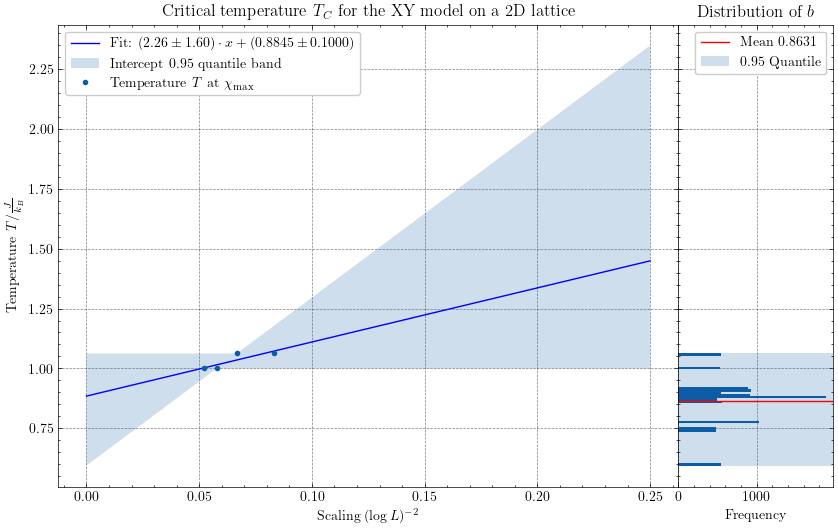

In [220]:
sampling = pd.Series(np.linspace(0, 0.25, num=100))

data = get_observable_max(con, simulation_id, Algorithm.Metropolis, Observable.MagneticSusceptibility)
data['size'] = data['lattice_size'].transform(lambda x: 1.0 / np.log(x)**2)

fig, ax = bootstrap_intercept(data, sampling)
ax[0].set_title('Critical temperature $T_C$ for the XY model on a 2D lattice')
ax[0].set_xlabel('Scaling $(\\log{L})^{-2}$')
ax[0].set_ylabel('Temperature $T / \\frac{J}{k_B}$')
ax[0].legend()

fig.savefig('figures/Metropolis/Critical_Temperature.pdf', dpi=dpi,  bbox_inches='tight')

Bootstrap slope: 2.6165 +- 1.6100
Bootstrap intercept: 0.8630 +- 0.1010
Linear slope: 2.2580 +- 1.6467
Linear intercept: 0.8845 +- 0.1010


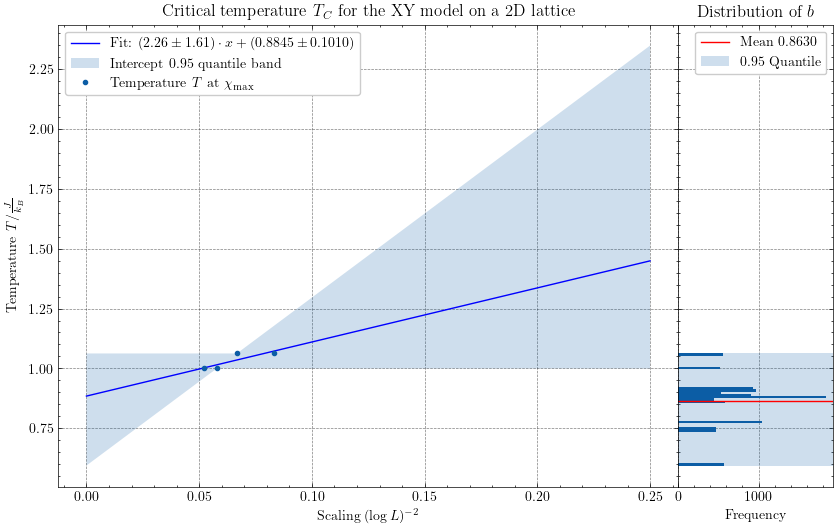

In [221]:
sampling = pd.Series(np.linspace(0, 0.25, num=100))

data = get_observable_max(con, simulation_id, Algorithm.Wolff, Observable.MagneticSusceptibility)
data['size'] = data['lattice_size'].transform(lambda x: 1.0 / np.log(x)**2)

fig, ax = bootstrap_intercept(data, sampling)
ax[0].set_title('Critical temperature $T_C$ for the XY model on a 2D lattice')
ax[0].set_xlabel('Scaling $(\\log{L})^{-2}$')
ax[0].set_ylabel('Temperature $T / \\frac{J}{k_B}$')
ax[0].legend()

fig.savefig('figures/Metropolis/Critical_Temperature.pdf', dpi=dpi,  bbox_inches='tight')

# Helicity Modulus

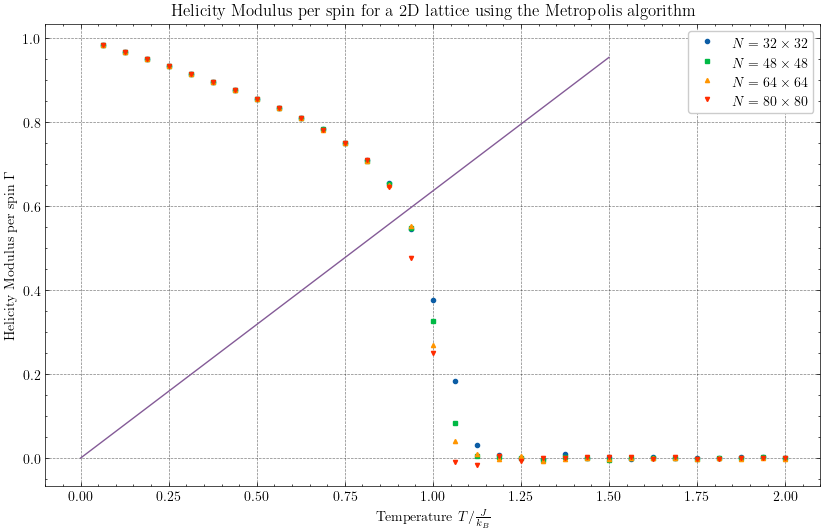

In [222]:
sampling = np.linspace(0, 1.5)
fig, ax = plot_observable_per_spin(con, simulation_id, Algorithm.Metropolis, Observable.HelicityModulus)
ax.plot(sampling, 2.0 * sampling / np.pi, '-', label='$\\frac{2}{\\pi T}$')
fig.savefig('figures/Metropolis/HelicityModulus.pdf', dpi=dpi,  bbox_inches='tight')

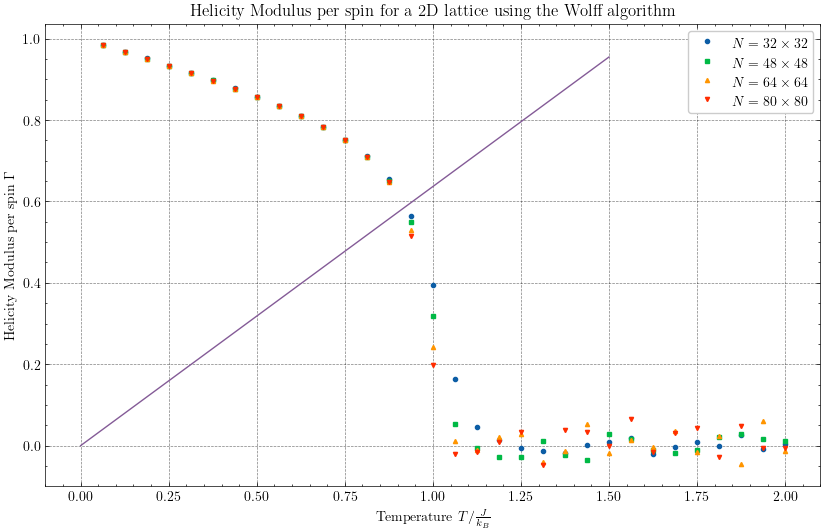

In [223]:
sampling = np.linspace(0, 1.5)
fig, ax = plot_observable_per_spin(con, simulation_id, Algorithm.Wolff, Observable.HelicityModulus)
ax.plot(sampling, 2.0 * sampling / np.pi, '-', label='$\\frac{2}{\\pi T}$')
fig.savefig('figures/Wolff/HelicityModulus.pdf', dpi=dpi,  bbox_inches='tight')

## Intersect

In [224]:
def line(p1, p2):
    A = (p1[1] - p2[1])
    B = (p2[0] - p1[0])
    C = (p1[0] * p2[1] - p2[0] * p1[1])
    return A, B, -C

def intersection(L1, L2):
    D  = L1[0] * L2[1] - L1[1] * L2[0]
    Dx = L1[2] * L2[1] - L1[1] * L2[2]
    Dy = L1[0] * L2[2] - L1[2] * L2[0]
    if D != 0:
        x = Dx / D
        y = Dy / D
        return x,y
    else:
        return False



def plot_helicity_modulus_intersect(con: sqlite3.Connection, simulation_id: int, alg: Algorithm) -> tuple[plt.Figure, plt.Axes, pd.DataFrame]:
    sizes = []
    temperatures = []
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

    fig, ax = plt.subplots()
    for i, size in enumerate(pd.read_sql_query(f'SELECT DISTINCT lattice_size FROM configurations c INNER JOIN metadata m ON c.metadata_id = m.metadata_id AND m.algorithm = {alg.value} WHERE c.simulation_id = {simulation_id}', con)['lattice_size']):
        data = pd.read_sql_query(f'SELECT temperature, e.mean, e.std_dev FROM configurations c INNER JOIN metadata m ON c.metadata_id = m.metadata_id AND m.algorithm = {alg.value} INNER JOIN estimates e ON e.configuration_id = c.configuration_id AND e.type_id = {Observable.HelicityModulus.value} WHERE c.simulation_id = \'{simulation_id}\' AND c.lattice_size = \'{size}\' ORDER BY temperature', con)
        data['reference'] = data['temperature'].transform(lambda x: 2.0 * x / np.pi)
        data['diff'] = data['mean'] - data['reference']

        idx = data['diff'].lt(0).idxmax()
        range = data.loc[idx - 1:idx]

        slope = range['mean'].diff().iloc[1] / range['temperature'].diff().iloc[1]
        intercept = data['mean'].iloc[idx] - slope * data['temperature'].iloc[idx]

        ax.errorbar(data['temperature'], data['mean'], yerr=data['std_dev'], color=colors[i])
        ax.plot(range['temperature'], range['temperature'] * slope + intercept, '--', color=colors[i])

        L1 = line([range['temperature'].iloc[0], range['mean'].iloc[0]], [range['temperature'].iloc[1], range['mean'].iloc[1]])
        L2 = line([0, 0], [1, 2.0 / np.pi])

        R = intersection(L1, L2)
        ax.plot(*R, 'o', label=f'Intersect $N = {size} \\times {size}$', color=colors[i], markersize=4)

        sizes.append(size)
        temperatures.append(R[0])

        ax.set_title(f'{Observable.HelicityModulus.name()} per spin for a 2D lattice using the {alg.name} algorithm')
        ax.set_xlabel('Temperature $T / \\frac{J}{k_B}$')
        ax.set_ylabel(f'{Observable.HelicityModulus.name()} per spin ${Observable.HelicityModulus.symbol()}$')

        ax.legend()
    return fig, ax, pd.DataFrame({'lattice_size': sizes, 'temperature': temperatures})

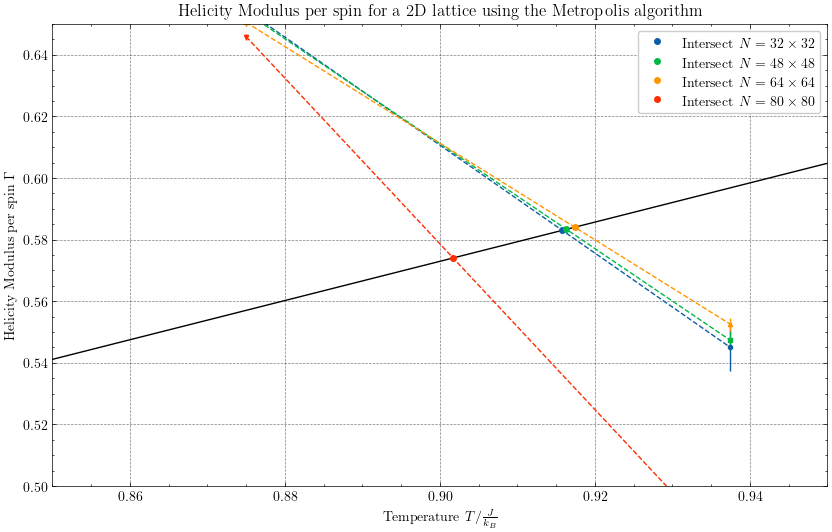

In [225]:
sampling = np.linspace(0, 1.5)

fig, ax, data = plot_helicity_modulus_intersect(con, simulation_id, Algorithm.Metropolis)
ax.plot(sampling, 2.0 * sampling / np.pi, 'k-', label='$\\frac{2}{\\pi T}$', zorder=0)
ax.set_xlim([0.85, 0.95])
ax.set_ylim([0.5, 0.65])
fig.savefig('figures/Metropolis/HelicityModulus_Intersect.pdf', dpi=dpi,  bbox_inches='tight')

Bootstrap slope: 0.1971 +- 0.2106
Bootstrap intercept: 0.8638 +- 0.0527
Linear slope: 0.1662 +- 0.2104
Linear intercept: 0.8706 +- 0.0527


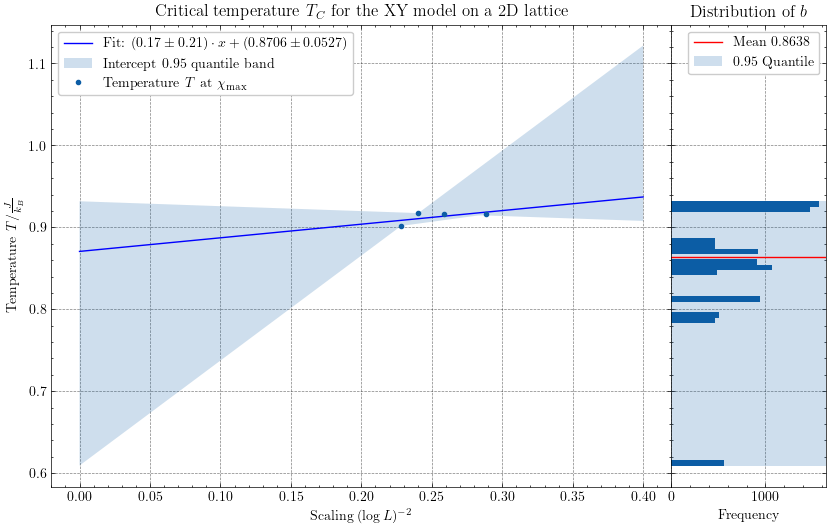

In [226]:
sampling = pd.Series(np.linspace(0, 0.4, num=100))
data['size'] = data['lattice_size'].transform(lambda x: 1.0 / np.log(x))

fig, ax = bootstrap_intercept(data, sampling)
ax[0].set_title('Critical temperature $T_C$ for the XY model on a 2D lattice')
ax[0].set_xlabel('Scaling $(\\log{L})^{-2}$')
ax[0].set_ylabel('Temperature $T / \\frac{J}{k_B}$')
ax[0].legend()

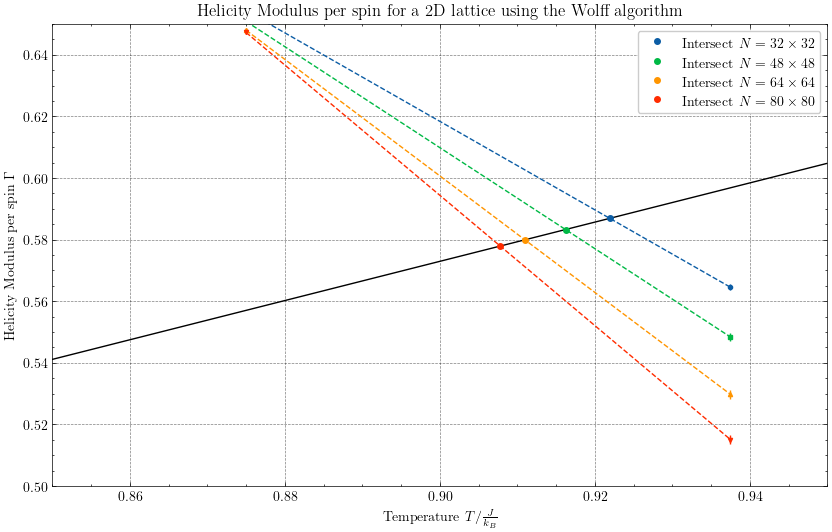

In [227]:
sampling = np.linspace(0, 1.5)

fig, ax, data = plot_helicity_modulus_intersect(con, simulation_id, Algorithm.Wolff)
ax.plot(sampling, 2.0 * sampling / np.pi, 'k-', label='$\\frac{2}{\\pi T}$', zorder=0)
ax.set_xlim([0.85, 0.95])
ax.set_ylim([0.5, 0.65])
fig.savefig('figures/Wolff/HelicityModulus_Intersect.pdf', dpi=dpi,  bbox_inches='tight')

Bootstrap slope: 0.2421 +- 0.0233
Bootstrap intercept: 0.8533 +- 0.0062
Linear slope: 0.2352 +- 0.0246
Linear intercept: 0.8545 +- 0.0062


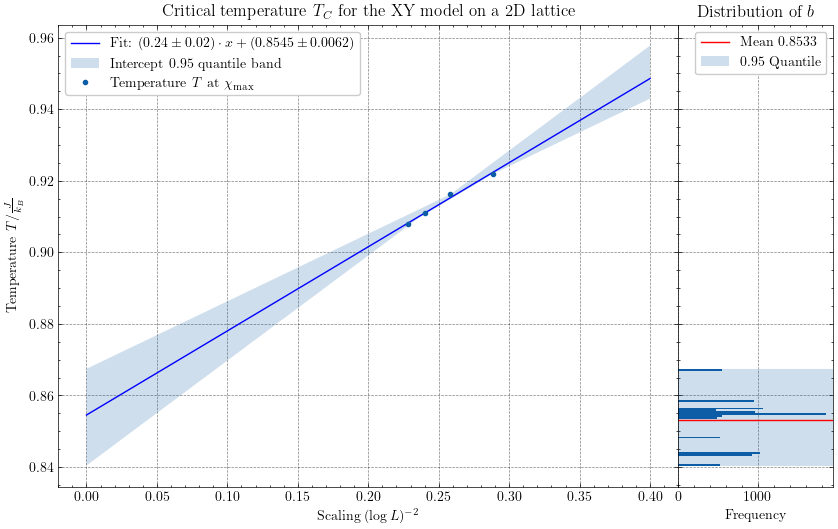

In [228]:
sampling = pd.Series(np.linspace(0, 0.4, num=100))
data['size'] = data['lattice_size'].transform(lambda x: 1.0 / np.log(x))

fig, ax = bootstrap_intercept(data, sampling)
ax[0].set_title('Critical temperature $T_C$ for the XY model on a 2D lattice')
ax[0].set_xlabel('Scaling $(\\log{L})^{-2}$')
ax[0].set_ylabel('Temperature $T / \\frac{J}{k_B}$')
ax[0].legend()